<a href="https://colab.research.google.com/github/KonstantinosBakalis/Facial-Verification-Siamese-Network./blob/main/Facial_Verification_with_a_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Siamese Neural Networks for One-shot Image Recognition

https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

# **1. Setup**


**1.1 Install Dependencies**

In [1]:
!pip install tensorflow keras opencv-python matplotlib tqdm

#!pip install tensorflow
#!pip install tensorflow keras
#!pip install opencv-python
#!pip install matplotlib
#!pip install tqdm

**1.2 Import Dependencies**

In [2]:
# Import standard dependencies
import cv2
import os
import shutil
import random
import numpy as np
from matplotlib import pyplot as plt

In [93]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf

In [4]:
# Model(inputs=[inputimage, verificatioimage], outputs-[1,0])

# Layer is a high level class which allowes us to define a custom layer and helps compile everything all together

# Conv2d this gives us a convolution network

# Dense is a fully connected layer

# MaxPooling 2D allows us to pull our layers together and shrink the information we have

# Input allows us to define what we are passing through our model

# Flatten takes all the information we have on the previous layer and flattens it into a single dimension

**1.3 Set GPU Growth**

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
gpus

[]

**1.4 Create Folder Structures**

In [7]:
#Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# **2. Collect Positives and Anchors**

**2.1 Untar Labelled Faces in the Wild Dataset**

In [9]:
# https://vis-www.cs.umass.edu/lfw/

In [10]:
import requests
from tqdm import tqdm

url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
response = requests.get(url, stream=True)

# Get the total size of the file
file_size = int(response.headers.get("Content-Length", 0))

# Create a progress bar with tqdm
progress = tqdm(response.iter_content(1024), f"Downloading {url}", total=file_size, unit="B", unit_scale=True, unit_divisor=1024)

with open('lfw.tgz', 'wb') as f:
    for data in progress.iterable:
        # Write data read to the file
        f.write(data)
        # Update the progress bar manually
        progress.update(len(data))

# Now, we can uncompress the downloaded file
!tar -xf lfw.tgz



In [11]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [12]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    print(os.path.join('lfw',directory,file))
    print(os.path.join(NEG_PATH, file))

**2.2 Collect Positive and Anchor Classes**

<IPython.core.display.Javascript object>

Saving files:   0%|          | 0/400 [00:00<?, ?it/s]

Saved to the following files:
/content/data/positive/36b5b64a-3520-11ee-8179-0242ac1c000c_positive.jpg
/content/data/positive/36c55622-3520-11ee-8179-0242ac1c000c_positive.jpg
/content/data/positive/36d4eb32-3520-11ee-8179-0242ac1c000c_positive.jpg
/content/data/positive/36e49a46-3520-11ee-8179-0242ac1c000c_positive.jpg
/content/data/positive/36f4418a-3520-11ee-8179-0242ac1c000c_positive.jpg


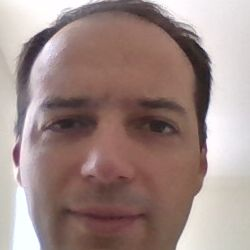

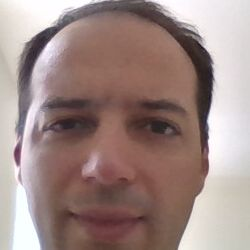

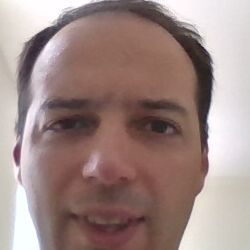

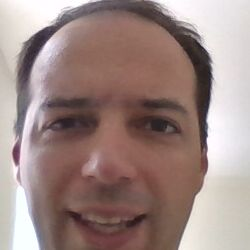

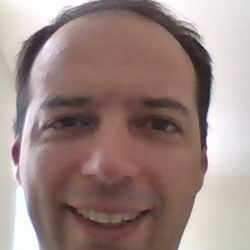

In [15]:
# Javascript that lets us collect positives and achors

from IPython.display import Image, display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os
import uuid
import time
from tqdm.notebook import tqdm

def take_photos(n=400, quality=0.8):
  js = Javascript('''
    async function takePhotos(n, quality) {
      const div = document.createElement('div');
      div.style.position = 'relative';
      div.style.display = 'inline-block';

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait until the video is playing and can have its properties accessed
      while(video.videoWidth === 0) {
        await new Promise(r => setTimeout(r, 100));
      }

      // Create buttons
      const captureAnchor = document.createElement('button');
      captureAnchor.textContent = 'Collect Anchors';
      div.appendChild(captureAnchor);

      const capturePositive = document.createElement('button');
      capturePositive.textContent = 'Collect Positives';
      div.appendChild(capturePositive);

      // Create an overlay of the "box"
      const overlay = document.createElement('div');
      overlay.style.position = 'absolute';
      overlay.style.top = '50%';
      overlay.style.left = '50%';
      overlay.style.width = '250px';
      overlay.style.height = '250px';
      overlay.style.transform = 'translate(-50%, -50%)';
      overlay.style.border = '2px solid red';
      overlay.style.pointerEvents = 'none';
      div.appendChild(overlay);

      document.body.appendChild(div);

      // Prepare to save images
      let dataUrlArray = [];
      let filename;

      // Wait for a button to be clicked, and set the filename accordingly.
      await new Promise((resolve) => {
        captureAnchor.onclick = () => {
          filename = 'anchor.jpg';
          resolve();
        }
        capturePositive.onclick = () => {
          filename = 'positive.jpg';
          resolve();
        }
      });

      // Take n photos
      for(let i = 0; i < n; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        const startX = Math.floor((video.videoWidth - 250) / 2);
        const startY = Math.floor((video.videoHeight - 250) / 2);

        const imageData = canvas.getContext('2d').getImageData(startX, startY, 250, 250);
        const outputCanvas = document.createElement('canvas');
        outputCanvas.width = 250;
        outputCanvas.height = 250;
        outputCanvas.getContext('2d').putImageData(imageData, 0, 0);

        dataUrlArray.push(outputCanvas.toDataURL('image/jpeg', quality));

        // Pause between photos
        await new Promise(r => setTimeout(r, 100));
      }

      stream.getVideoTracks()[0].stop();
      div.remove();
      return [dataUrlArray, filename];
    }
    ''')
  display(js)
  data_urls, filename = eval_js('takePhotos({}, {})'.format(n, quality))
  files = []
  progress_bar = tqdm(total=len(data_urls), desc="Saving files", bar_format='{l_bar}{bar}{r_bar}')
  for data_url in data_urls:
      binary = b64decode(data_url.split(',')[1])
      unique_id = str(uuid.uuid1())
      filename_with_id = unique_id + "_" + filename
      if 'anchor' in filename:
        directory = "/content/data/anchor"
      else:
        directory = "/content/data/positive"
      if not os.path.exists(directory):
        os.makedirs(directory)
      file_path = os.path.join(directory, filename_with_id)
      with open(file_path, 'wb') as f:
        f.write(binary)
      files.append(file_path)
      time.sleep(0.1)
      progress_bar.update(1)
  progress_bar.close()
  return files

try:
  filenames = take_photos()
  print('Saved to the following files:')
  for filename in filenames[:5]:
    print(filename)
  # Display the first few images
  for filename in filenames[:5]:
    display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**2.3 - Data Augmentation**

In [16]:
def data_aug(img, seed):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(seed, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(seed, 3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(seed, seed + 1))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(seed, seed + 2))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(seed, seed + 3))
        data.append(img)
    return data

#def data_aug(img, seed):
#    img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(seed, 2))
#    plt.imshow(img.numpy().astype('uint8'))
#    plt.title("After brightness")
#    plt.show()
#
#    img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(seed, 3))
#    plt.imshow(img.numpy().astype('uint8'))
#    plt.title("After contrast")
#    plt.show()
#
#    img = tf.image.stateless_random_flip_left_right(img, seed=(seed, seed + 1))
#    plt.imshow(img.numpy().astype('uint8'))
#    plt.title("After flip")
#    plt.show()
#
#    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(seed, seed + 2))
#    plt.imshow(img.numpy().astype('uint8'))
#    plt.title("After jpeg quality")
#    plt.show()
#
#    img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(seed, seed + 3))
#    plt.imshow(img.numpy().astype('uint8'))
#    plt.title("After saturation")
#    plt.show()
#
#    return img

def read_and_augment(img_path, folder_path):
    img_path_str = img_path.numpy().decode("utf-8")
    img = tf.io.read_file(img_path_str)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [250, 250])
    img = img / 255.0  # Scaling the values to 0-1 (if needed)
    img = img * 255  # Scaling the values to 0-255
    img = tf.cast(img, tf.uint8) # Casting to uint8
    img_name = os.path.splitext(os.path.basename(img_path_str))[0]
# Test code
#    plt.imshow(img.numpy())
#    plt.title("Original Image")
#    plt.show()
#
#    augmented_image = data_aug(img, seed=np.random.randint(100))
#    file_path = os.path.join(folder_path, f"{img_name}_aug.jpeg")
#    tf.io.write_file(file_path, tf.image.encode_jpeg(augmented_image))
#
# end of test code
    augmented_images = data_aug(img, seed=np.random.randint(100))
    for i, img_aug in enumerate(augmented_images):
        file_path = os.path.join(folder_path, f"{img_name}_aug_{i}.jpeg")
        tf.io.write_file(file_path, tf.image.encode_jpeg(img_aug))


def load_and_augment_images():
    ANC_PATH = "/content/data/anchor"
    POS_PATH = "/content/data/positive"
    paths = [POS_PATH, ANC_PATH]

    for path in paths:
        img_paths = [os.path.join(path, f) for f in os.listdir(path)]
        with tqdm(total=len(img_paths), desc=f"Processing {path}") as pbar:
            for img_path in img_paths:
                read_and_augment(tf.constant(img_path), path)
                pbar.update(1)

    print("Augmentation complete.")

load_and_augment_images()


Processing /content/data/positive:   0%|          | 0/400 [00:00<?, ?it/s]

Processing /content/data/anchor:   0%|          | 0/400 [00:00<?, ?it/s]

Augmentation complete.


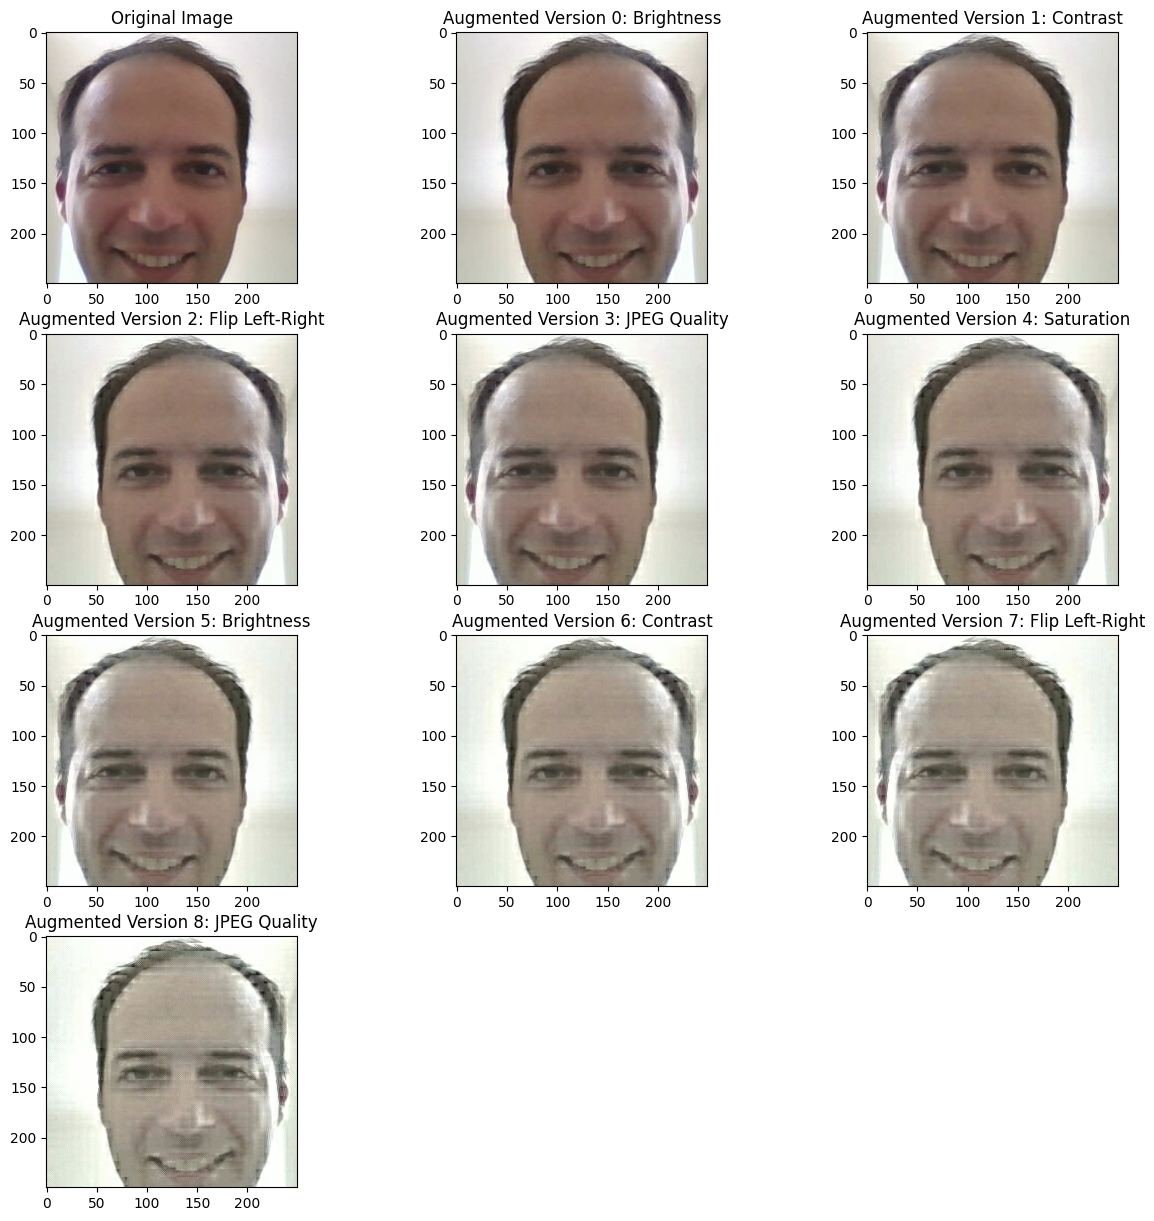

In [17]:
def show_random_image(path):
    img_paths = [os.path.join(path, f) for f in os.listdir(path) if all(f"_aug_{i}.jpeg" not in f for i in range(9))]
    random_img_path = np.random.choice(img_paths)
    img_name = os.path.splitext(os.path.basename(random_img_path))[0]

    plt.figure(figsize=(15, 15))

    # Original Image
    original_img = tf.io.read_file(random_img_path)
    original_img = tf.image.decode_jpeg(original_img, channels=3)
    plt.subplot(4, 3, 1)
    plt.imshow(original_img.numpy())
    plt.title("Original Image")

    # Augmented Images
    titles = [
        "Brightness",
        "Contrast",
        "Flip Left-Right",
        "JPEG Quality",
        "Saturation",
        "Brightness",
        "Contrast",
        "Flip Left-Right",
        "JPEG Quality" # Add or change these titles based on the transformations
    ]
    for i in range(9):
        aug_img_path = os.path.join(path, f"{img_name}_aug_{i}.jpeg")
        aug_img = tf.io.read_file(aug_img_path)
        aug_img = tf.image.decode_jpeg(aug_img, channels=3)
        plt.subplot(4, 3, i + 2)
        plt.imshow(aug_img.numpy())
        plt.title(f"Augmented Version {i}: {titles[i]}")

    plt.show()

show_random_image(POS_PATH)

In [ ]:
#import os
#import glob

# Folder paths
#ANC_PATH = "/content/data/anchor"
#POS_PATH = "/content/data/positive"
#NEG_PATH = "/content/data/negative"

# Function to delete augmented images
#def delete_augmented_images(folder_path):
    # Search for all files ending with "_aug_" pattern in the filename
#    augmented_files = glob.glob(os.path.join(folder_path, "*_aug_*.jpeg"))

    # Delete each file found
#    for file_path in augmented_files:
#        print(f"Deleting {file_path} ...")
#        os.remove(file_path)
#    print(f"Deleted {len(augmented_files)} augmented files from {folder_path}")

# Delete augmented images from specified folders
#delete_augmented_images(ANC_PATH)
#delete_augmented_images(POS_PATH)
#delete_augmented_images(NEG_PATH)  # If there are augmented images in the negative path

#print("Deletion of augmented images complete.")


# **3. Load and Preprocess Images**

**3.1 Get Image Directories**

In [18]:
ANC_PATH = "/content/data/anchor"
POS_PATH = "/content/data/positive"
NEG_PATH = "/content/data/negative"

anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(3000)


**3.2 Preprocessing - Scale and Resize**

In [19]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the image to be 105x105x3
    img = tf.image.resize(img,(105,105))
    # Scale image to be between 0 and 1
    img = img / 255.0
    # Return the image
    return img

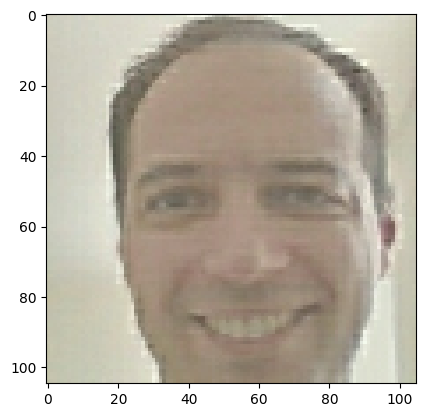

In [20]:
# Define the directory
dir_path = '/content/data/positive'

# Get a list of all filenames in that directory
filenames = os.listdir(dir_path)

# Choose a random filename
random_filename = random.choice(filenames)

# Get the full path to the randomly chosen file
full_path = os.path.join(dir_path, random_filename)

# Now you can preprocess the image
img = preprocess(full_path)

# Plot the image
plt.imshow(img)

In [21]:
img.numpy().max()

0.99832374

**3.3 Create Labelled Dataset**

In [22]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
samples.next()

(b'/content/data/anchor/be775724-351f-11ee-8179-0242ac1c000c_anchor.jpg',
 b'/content/data/positive/48425b34-3520-11ee-8179-0242ac1c000c_positive.jpg',
 1.0)

**3.4 Build Train and Test Partition**

In [25]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [27]:
samples = data.as_numpy_iterator()

In [28]:
samples.next()

(array([[[0.8093371 , 0.78580767, 0.73874885],
         [0.8581633 , 0.8346339 , 0.78757507],
         [0.90114266, 0.87761325, 0.8305544 ],
         ...,
         [0.9595594 , 0.96348095, 0.9321084 ],
         [0.9596572 , 0.96357876, 0.9322062 ],
         [0.95172733, 0.9556489 , 0.92427635]],
 
        [[0.8003668 , 0.7768374 , 0.7297786 ],
         [0.8170468 , 0.7935174 , 0.7464586 ],
         [0.87295586, 0.84942645, 0.8023676 ],
         ...,
         [0.9548086 , 0.95873016, 0.9273576 ],
         [0.96050423, 0.9644258 , 0.93305326],
         [0.9487395 , 0.9526611 , 0.92128855]],
 
        [[0.82138187, 0.79785246, 0.75079364],
         [0.8182673 , 0.7947379 , 0.74767905],
         [0.8598506 , 0.8363212 , 0.78926235],
         ...,
         [0.9493931 , 0.95331466, 0.9219421 ],
         [0.95116717, 0.95508873, 0.9237162 ],
         [0.9390289 , 0.9429505 , 0.91157794]],
 
        ...,
 
        [[0.6933595 , 0.69550705, 0.6812213 ],
         [0.6673802 , 0.66952777, 0.65524

In [29]:
len(samples.next())

3

In [30]:
samp = samples.next()

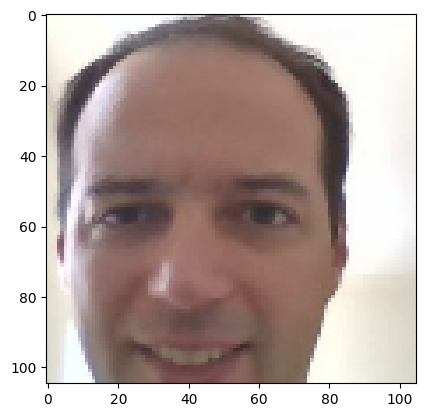

In [31]:
plt.imshow(samp[0])

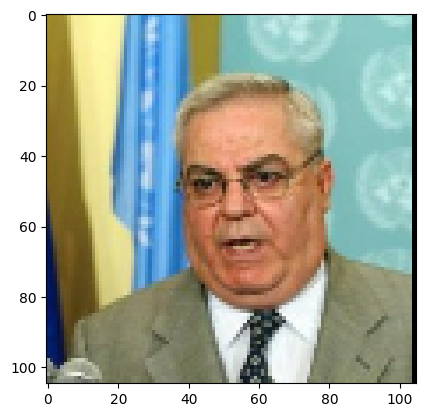

In [32]:
plt.imshow(samp[1])

In [33]:
# We are making sure that labelling and preprocessing is working correctly
samp[2]

0.0

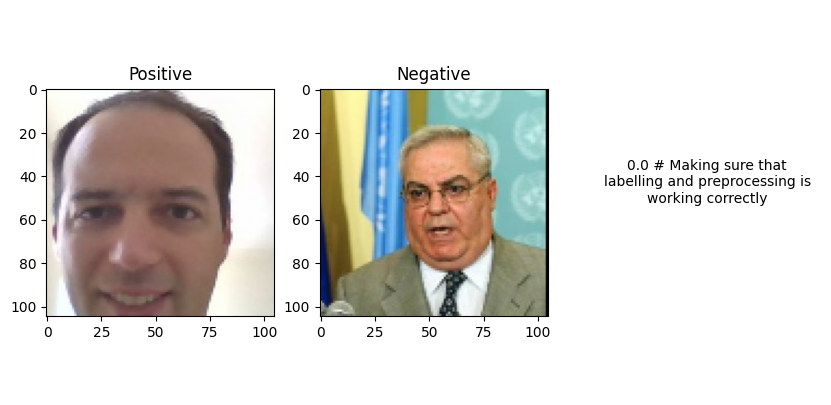

In [34]:
import textwrap

plt.figure(figsize=(10, 5))

# Display the "Positive" image
plt.subplot(1, 3, 1)
plt.imshow(samp[0])
plt.title("Positive")
plt.axis('on') # Optional, to hide the axis

# Display the "Negative" image
plt.subplot(1, 3, 2)
plt.imshow(samp[1])
plt.title("Negative")
plt.axis('on') # Optional, to hide the axis

# Display the comment
plt.subplot(1, 3, 3)
comment = str(samp[2]) + "\n# Making sure that labelling and preprocessing is working correctly"
wrapped_comment = textwrap.fill(comment, width=30) # Adjust width to your preference
plt.text(0.5, 0.5, wrapped_comment, ha='center')
plt.axis('off') # Hide the axis

plt.show()

In [35]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [36]:
train_samples = train_data.as_numpy_iterator()

In [37]:
train_sample = train_samples.next()

In [38]:
len(train_sample[0])

16

In [39]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# **4. Model Engineering**

**4.1 Build Embedding Layer**

In [110]:
inp = Input(shape=(105,105,3), name='input_image')

In [111]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [112]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)

In [113]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d_8')>

In [114]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [115]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d_6')>

In [116]:
c2 = Conv2D(128,(7,7), activation='relu')(m1)

In [117]:
c2

<KerasTensor: shape=(None, 42, 42, 128) dtype=float32 (created by layer 'conv2d_9')>

In [118]:
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [119]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_7')>

In [120]:
c3 = Conv2D(128,(4,4), activation='relu')(m2)

In [121]:
c3

<KerasTensor: shape=(None, 18, 18, 128) dtype=float32 (created by layer 'conv2d_10')>

In [122]:
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [123]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_8')>

In [124]:
c4 = Conv2D(256,(4,4),activation='relu')(m3)

In [125]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_11')>

In [126]:
f1 = Flatten()(c4)

In [127]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten_2')>

In [128]:
d1 = Dense(4096, activation='sigmoid')(f1)

In [129]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_4')>

In [130]:
# There are easier ways to create this model but we are going to create this embadding from the paper to show that we can impliment newly created papers
def make_embedding():
  inp = Input(shape=(105,105,3), name='input_image')

  # First block
  c1 = Conv2D(64,(10,10), activation='relu')(inp)
  m1 = MaxPooling2D((2,2), padding='same')(c1)  # Modify here

  # Second block
  c2 = Conv2D(128,(7,7), activation='relu')(m1)
  m2 = MaxPooling2D((2,2), padding='same')(c2)  # And here

  # Third block
  c3 = Conv2D(128,(4,4), activation='relu')(m2)
  m3 = MaxPooling2D((2,2), padding='same')(c3)  # And here

  # Final embedding block
  c4 = Conv2D(256,(4,4),activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [131]:
Model(inputs=[inp], outputs=[d1], name='embedding')

In [132]:
embedding = make_embedding()

In [133]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 128)       26

**4.2 Build Distance Layer**

In [134]:
# Siamese L1 Distance class
class L1Dist(Layer):

  # Init method - inheritance
  def __init__(self, **kwargs):
    super().__init__()

  #Magic happens here - similarity calculation and returns either 1 or 0
  def call(self,input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [135]:
l1 = L1Dist()

In [136]:
# l1(anchor_embedding, validation_embedding)

**4.3 Make Siamese Model**

In [137]:
input_image = Input(name='input_img', shape=(105,105,3))

In [138]:
embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [139]:
validation_image = Input(name='validation_img', shape=(105,105,3))

In [140]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [141]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [142]:
siamese_layer = L1Dist()

In [143]:
distances = siamese_layer(inp_embedding, val_embedding)

In [144]:
classifier = Dense(1, activation='sigmoid')(distances)

In [145]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [146]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [147]:
siamese_network

In [148]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [149]:
def make_siamese_model():

  # Anchor image input in the netowrk
  input_image = Input(name='input_img', shape=(105,105,3))

  # Validation image in the network
  validation_image = Input(name='validation_img', shape=(105,105,3))

  # Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classification layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [150]:
siamese_model = make_siamese_model()

In [151]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# **5. Training**

**5.1 Setup Loss and Optimiser**

In [152]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [153]:
opt = tf.keras.optimizers.Adam(1e-4) #0.001

**5.2 Establish Checkpoints**

In [154]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

**5.3 Build Train Step Function**

In [155]:
test_batch = train_data.take(1)

In [156]:
batch_1 = next(iter(test_batch))

In [157]:
batch_1

(<tf.Tensor: shape=(16, 105, 105, 3), dtype=float32, numpy=
 array([[[[0.69495577, 0.69495577, 0.64789695],
          [0.7281913 , 0.7281913 , 0.6811325 ],
          [0.761449  , 0.761449  , 0.71439016],
          ...,
          [0.80784315, 0.8117647 , 0.7921569 ],
          [0.80784315, 0.8117647 , 0.7921569 ],
          [0.8       , 0.8039216 , 0.78431374]],
 
         [[0.68878883, 0.68878883, 0.64173   ],
          [0.70670265, 0.70670265, 0.6596438 ],
          [0.7498333 , 0.7498333 , 0.70277447],
          ...,
          [0.80784315, 0.8117647 , 0.7921569 ],
          [0.80784315, 0.8117647 , 0.7921569 ],
          [0.80784315, 0.8117647 , 0.7921569 ]],
 
         [[0.6955182 , 0.6919701 , 0.6449113 ],
          [0.69075626, 0.68720824, 0.6401494 ],
          [0.7308679 , 0.72731984, 0.680261  ],
          ...,
          [0.80784315, 0.8117647 , 0.7921569 ],
          [0.80784315, 0.8117647 , 0.7921569 ],
          [0.80214757, 0.80606914, 0.7864613 ]],
 
         ...,
 
      

In [158]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
      # Get anchor and positive/negative image
      X = batch[:2]
      # Get label
      y = batch[2]

      # Forward pass
      yhat = siamese_model(X, training=True)
      # Calculate loss
      loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

**5.4 Build training Loop**

In [159]:
def train(model, data, EPOCHS, checkpoint, checkpoint_prefix):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
      print('\n Epoch{}/{}'.format(epoch, EPOCHS))
      progbar = tf.keras.utils.Progbar(len(data))

      # Creating a matric object
      r = Recall()
      p = Precision()

    # Loop through each batch
      for idx, batch in enumerate(data):
        # Run train step here
        loss = train_step(batch)
        yhat = siamese_model.predict(batch[:2])
        r.update_state(batch[2], yhat)
        p.update_state(batch[2], yhat)
        progbar.update(idx+1)
      print(loss.numpy(), r.result().numpy(), p.result().numpy())

    # Save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

**5.5 Train the model**

In [160]:
EPOCHS = 3

In [161]:
train(siamese_model, train_data, EPOCHS, checkpoint, checkpoint_prefix)


 Epoch1/3
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
35/35 [==============================] - 259s 7s/step
0.17522648 0.78417265 0.98642534

 Epoch2/3
35/35 [==============================] - 261s 7s/step
0.08527531 0.98188406 0.98188406

 Epoch3/3
35/35 [==============================] - 246s 7s/step
0.011841474 1.0 0.9894366


# **6. Evaluate Model**

**6.1 Import Metrics**

In [162]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

**6.2 Make Predictions**

In [163]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [164]:
test_var = test_data.as_numpy_iterator().next()

In [165]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[9.9844944e-01],
       [2.8649315e-06],
       [6.6918600e-01],
       [3.4186348e-07],
       [9.8728395e-01],
       [2.8937197e-06],
       [9.4400316e-01],
       [9.9999762e-01],
       [4.6395016e-06],
       [9.3418389e-04],
       [9.9770397e-01],
       [9.8314756e-01],
       [8.7526429e-01],
       [6.2104589e-03],
       [9.9239981e-01],
       [9.9930054e-01]], dtype=float32)

In [166]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]

**6.3 Calculating Metrics**

In [167]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result().numpy()

1.0

In [168]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result().numpy()

1.0

**6.4 Visualise results**

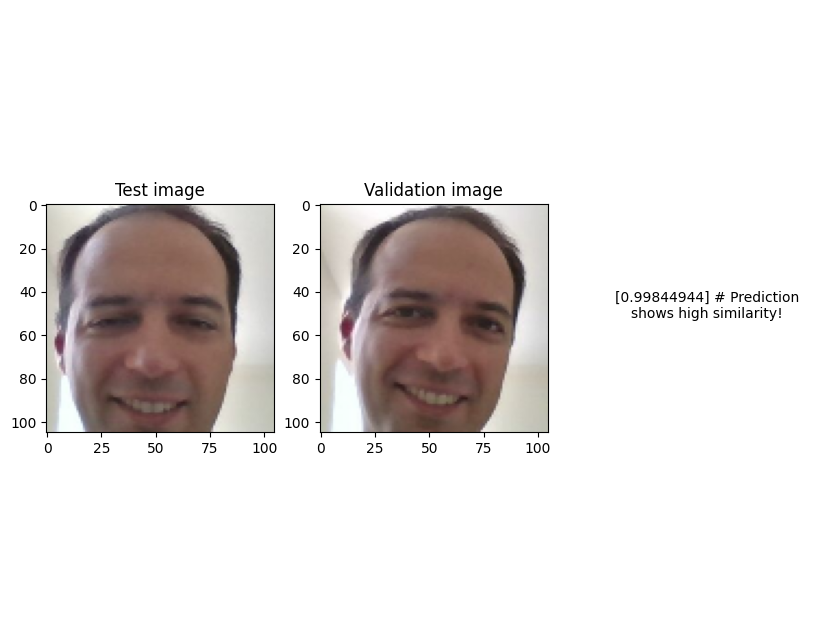

In [169]:
import textwrap

plt.figure(figsize=(10, 8))

# Set first subplot for "Positive" image
plt.subplot(1, 3, 1)
plt.imshow(test_input[0])
plt.title("Test image")
plt.axis('on') # Optional, to hide the axis

# Set second subplot for "Negative" image
plt.subplot(1, 3, 2)
plt.imshow(test_val[0])
plt.title("Validation image")
plt.axis('on') # Optional, to hide the axis

# Display the comment (you'll need to define `comment` appropriately for your code)
plt.subplot(1, 3, 3)
comment = str(y_hat[0]) + "\n# Prediction shows high similarity!"
wrapped_comment = textwrap.fill(comment, width=30) # Adjust width to your preference
plt.text(0.5, 0.5, wrapped_comment, ha='center')
plt.axis('off') # Hide the axis

plt.show()


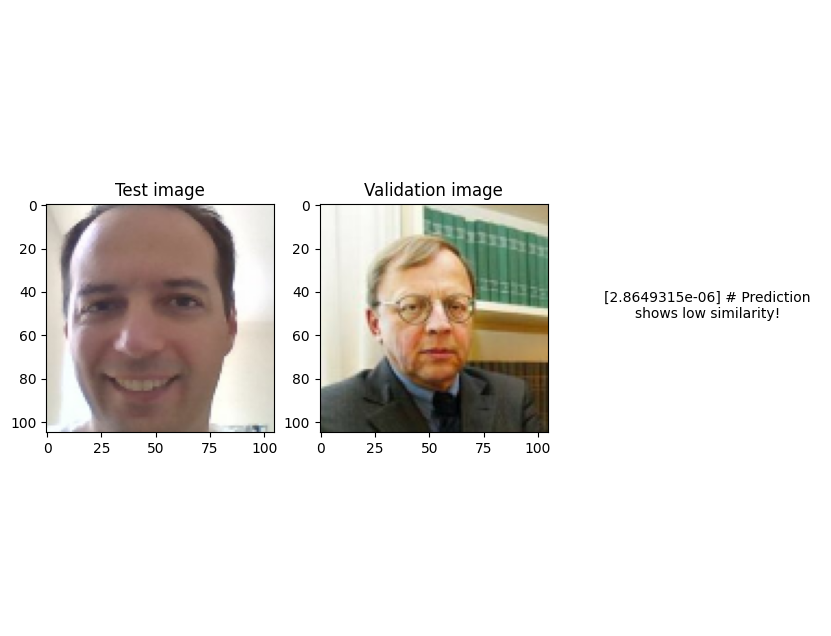

In [170]:
import textwrap

plt.figure(figsize=(10, 8))

# Set first subplot for "Positive" image
plt.subplot(1, 3, 1)
plt.imshow(test_input[1])
plt.title("Test image")
plt.axis('on') # Optional, to hide the axis

# Set second subplot for "Negative" image
plt.subplot(1, 3, 2)
plt.imshow(test_val[1])
plt.title("Validation image")
plt.axis('on') # Optional, to hide the axis

# Display the comment (you'll need to define `comment` appropriately for your code)
plt.subplot(1, 3, 3)
comment = str(y_hat[1]) + "\n# Prediction shows low similarity!"
wrapped_comment = textwrap.fill(comment, width=30) # Adjust width to your preference
plt.text(0.5, 0.5, wrapped_comment, ha='center')
plt.axis('off') # Hide the axis

plt.show()

# **7. Save Model**

In [171]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [172]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [173]:
# Make predictions with a reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.9844944e-01],
       [2.8649315e-06],
       [6.6918600e-01],
       [3.4186348e-07],
       [9.8728395e-01],
       [2.8937197e-06],
       [9.4400316e-01],
       [9.9999762e-01],
       [4.6395016e-06],
       [9.3418389e-04],
       [9.9770397e-01],
       [9.8314756e-01],
       [8.7526429e-01],
       [6.2104589e-03],
       [9.9239981e-01],
       [9.9930054e-01]], dtype=float32)

In [174]:
# View model summary
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x79a52d45e110>>

# **8. Real Time Test**

In [175]:
# Defining the directory names for our Test
base_dir = 'application_data'
input_img_dir = 'input_image'
verification_img_dir = 'verification_images'

# Using os.path.join() to create full paths
full_input_img_dir = os.path.join(base_dir, input_img_dir)
full_verification_img_dir = os.path.join(base_dir, verification_img_dir)

# Create the directories
os.makedirs(full_input_img_dir, exist_ok=True)
os.makedirs(full_verification_img_dir, exist_ok=True)

print(os.listdir(base_dir))

['verification_images', 'input_image']


In [176]:
import shutil

# Define directories
positives_dir = '/content/data/positive'
verification_img_dir = 'application_data/verification_images'

# List all files in the positives directory
all_files = os.listdir(positives_dir)

# Randomly select 100 files
selected_files = random.sample(all_files, 50)

# Copy each selected file into the verification_images directory
for file in selected_files:
    shutil.copy(os.path.join(positives_dir, file), verification_img_dir)

# Optional: print out the first 10 file names that have been copied
print("First 10 files copied:", selected_files[:10])

First 10 files copied: ['3e091d56-3520-11ee-8179-0242ac1c000c_positive_aug_3.jpeg', '3fbe1cb4-3520-11ee-8179-0242ac1c000c_positive_aug_4.jpeg', '47684d04-3520-11ee-8179-0242ac1c000c_positive_aug_1.jpeg', '466f7cf6-3520-11ee-8179-0242ac1c000c_positive_aug_0.jpeg', '3ffc7cc0-3520-11ee-8179-0242ac1c000c_positive.jpg', '3add2c58-3520-11ee-8179-0242ac1c000c_positive_aug_3.jpeg', '4bd9be72-3520-11ee-8179-0242ac1c000c_positive_aug_3.jpeg', '3e572320-3520-11ee-8179-0242ac1c000c_positive_aug_4.jpeg', '3d9c2444-3520-11ee-8179-0242ac1c000c_positive_aug_2.jpeg', '40c6c232-3520-11ee-8179-0242ac1c000c_positive_aug_5.jpeg']


**8.1 Verification Function**

In [177]:
def verify(frame, model, detection_threshold, verification_threshold):
  # Build results array
  results = []
  for image in os.listdir(os.path.join('application_data', 'verification_images')):
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

    # Make Predictions
    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)

  # Detection Threshold: Metric above which a prediction is considered positive
  detection = np.sum(np.array(results) > detection_threshold)

  # Verification Threshold: Proportion of positive predictions / total positive samples
  verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
  verified = verification > verification_threshold

  return results, verified

**8.2 OpenCV Real Time Verification**

<IPython.core.display.Javascript object>

Saved to: application_data/input_image/input_image.jpg


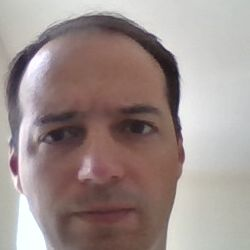

1/1 [==============================] - 0s 115ms/step
True


In [178]:
from IPython.display import Image, display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os
import tensorflow as tf
import numpy as np

def take_photo(model, detection_threshold=0.5, verification_threshold=0.5, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      div.style.position = 'relative';
      div.style.display = 'inline-block';

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait until the video is playing and can have its properties accessed
      while(video.videoWidth === 0) {
        await new Promise(r => setTimeout(r, 100));
      }

      // Create an overlay of the "box"
      const overlay = document.createElement('div');
      overlay.style.position = 'absolute';
      overlay.style.top = '50%';
      overlay.style.left = '50%';
      overlay.style.width = '250px';
      overlay.style.height = '250px';
      overlay.style.transform = 'translate(-50%, -50%)';
      overlay.style.border = '2px solid red';
      overlay.style.pointerEvents = 'none';
      div.appendChild(overlay);

      // Create button to capture image
      const captureButton = document.createElement('button');
      captureButton.textContent = 'Capture Verification Image';
      div.appendChild(captureButton);

      document.body.appendChild(div);

      // Prepare to save image
      let dataUrl;

      // Wait for the button to be clicked.
      await new Promise((resolve) => {
        captureButton.onclick = () => {
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);

          const startX = Math.floor((video.videoWidth - 250) / 2);
          const startY = Math.floor((video.videoHeight - 250) / 2);
          const imageData = canvas.getContext('2d').getImageData(startX, startY, 250, 250);
          const outputCanvas = document.createElement('canvas');
          outputCanvas.width = 250;
          outputCanvas.height = 250;
          outputCanvas.getContext('2d').putImageData(imageData, 0, 0);

          dataUrl = outputCanvas.toDataURL('image/jpeg', quality);
          resolve();
        };
      });

      stream.getVideoTracks()[0].stop();
      div.remove();
      return dataUrl;
    }
    ''')
  display(js)
  data_url = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data_url.split(',')[1])
  directory = 'application_data/input_image'
  if not os.path.exists(directory):
    os.makedirs(directory)
  file_path = os.path.join(directory, 'input_image.jpg')
  with open(file_path, 'wb') as f:
    f.write(binary)
  print('Saved to:', file_path)
  display(Image(file_path))

  # Preprocess the image
  frame = preprocess(file_path)

  # Run verification
  results, verified = verify(frame, model, detection_threshold, verification_threshold)
  print(verified)

# Call the take_photo function with your model
try:
  take_photo(model)
except Exception as err:
  print(str(err))


In [179]:
!zip -r /content/application_data.zip /content/application_data
from google.colab import files
files.download('/content/application_data.zip')

  adding: content/application_data/ (stored 0%)
  adding: content/application_data/verification_images/ (stored 0%)
  adding: content/application_data/verification_images/40c6c232-3520-11ee-8179-0242ac1c000c_positive_aug_5.jpeg (deflated 2%)
  adding: content/application_data/verification_images/47971ce2-3520-11ee-8179-0242ac1c000c_positive_aug_3.jpeg (deflated 3%)
  adding: content/application_data/verification_images/3fbe1cb4-3520-11ee-8179-0242ac1c000c_positive_aug_4.jpeg (deflated 1%)
  adding: content/application_data/verification_images/39d36142-3520-11ee-8179-0242ac1c000c_positive_aug_4.jpeg (deflated 3%)
  adding: content/application_data/verification_images/38e8a3c8-3520-11ee-8179-0242ac1c000c_positive_aug_6.jpeg (deflated 1%)
  adding: content/application_data/verification_images/4ab1c2d8-3520-11ee-8179-0242ac1c000c_positive_aug_0.jpeg (deflated 2%)
  adding: content/application_data/verification_images/4739a648-3520-11ee-8179-0242ac1c000c_positive_aug_6.jpeg (deflated 2%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [180]:
files.download('/content/siamesemodel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>